## 1st variant
### Dynamic Bayesian Network Structure Learning with hybrid network = (classic) encoder + (quantum) circuit.
This is an example with real test data and dummy generated training data of 24 variables, that means 48 vertices (24 for t and 24 for t+1).    
input=(1,48)
n_qubits=2 * ceil(log2(2 * nnodes)) -> for nnodes = 24, n_qubits = 12    
where first six digits correspond to vertice where the edge begins and six last digits correspond to vertice where edge ends i.e. 000010000101 corresponds to: vertice_2 ---> vertice_5  
It was tested with two sets of test data at the end of the notebook. The last test is with real data


In [131]:
! pip3 install torch==1.10.2+cpu torchvision==0.11.3+cpu -f https://download.pytorch.org/whl/cpu/torch_stable.html
import pandas as pd
from torch.utils.data import Dataset
import torch
import torchvision
from torch import nn
import numpy as np
import pennylane as qml
import random
import networkx as nx
from matplotlib import pyplot as plt

Looking in links: https://download.pytorch.org/whl/cpu/torch_stable.html


In [149]:
path = "small_elu.csv"

In [165]:
ds = pd.read_csv(path)
ds

,NAME,T,GENE,t0,t1
0,YAL013W,0,DEP1,0.00,-0.23
1,YMR039C,0,SUB1,-0.10,-0.35
2,YDR207C,0,UME6,0.01,-0.19
3,YLR295C,0,ATP14,0.10,-0.05
4,YDR310C,0,SUM1,-0.09,-0.03
...,...,...,...,...,...
211,YLR229C,8,CDC42,0.33,0.04
212,YLR295C,8,ATP14,0.10,-0.10
213,YMR039C,8,SUB1,0.33,0.12
214,YGL167C,8,PMR1,-0.19,-0.13


In [166]:
nnodes = 24
ds = ds.sort_values(by=['T', 'NAME'])
t01_list = [ds[['t0','t1']].iloc[f*nnodes:(f+1)*nnodes].values.T for f in range(len(ds)//nnodes)]
dst = pd.DataFrame({'T':range(len(ds)//nnodes), 't01':t01_list})
dst
nodes_names = {f:ds[['NAME']].iloc[0:nnodes].values[f][0] for f in range(nnodes)}
nodes_genes = {f:ds[['GENE']].iloc[0:nnodes].values[f][0] for f in range(nnodes)}

In [167]:
dst['y'] = [range(4) for i in range(9)]
dst

,T,t01,y
0,0,"[[0.0, 0.38, -0.78, 0.01, -0.09, -0.27, 0.32, ...","(0, 1, 2, 3)"
1,1,"[[-0.23, -0.08, -0.85, -0.19, -0.03, -0.1, 0.0...","(0, 1, 2, 3)"
2,2,"[[0.0, 0.05, -0.07, -0.21, 0.36, -0.02, -0.08,...","(0, 1, 2, 3)"
3,3,"[[0.21, 0.28, 0.51, -0.21, 0.3, 0.02, 0.08, 0....","(0, 1, 2, 3)"
4,4,"[[-0.02, -0.34, 0.64, 0.22, 0.19, 0.15, -0.08,...","(0, 1, 2, 3)"
5,5,"[[-0.02, -0.07, 0.6, 0.15, 0.3, 0.34, -0.15, -...","(0, 1, 2, 3)"
6,6,"[[-0.33, -0.05, 0.58, -0.13, -0.23, -0.24, -0....","(0, 1, 2, 3)"
7,7,"[[0.03, -0.25, 0.62, -0.45, 0.22, 0.07, 0.1, -...","(0, 1, 2, 3)"
8,8,"[[-0.23, -0.2, 0.61, -0.64, 0.25, 0.19, 0.1, -...","(0, 1, 2, 3)"


In [136]:
scale = np.frompyfunc(lambda x, min, max: (x-min)/(max - min), 3, 1)

def get_edges(n=4):
    num_edges = random.randint(n, n+3)
    e1 = [(random.randint(0, n-1),random.randint(0, (n*2)-1)) for f in range(num_edges//2)]
    e2 = [(random.randint(0, (n*2)-1),random.randint(n, (n*2)-1)) for f in range(num_edges//2)]
    return e1 + e2

def get_t0(edges, weights, n=4):
    t0 = np.zeros(n) + 0.01
    edges0 = [edge for i in range(n) for edge in edges if edge[0] == i and edge[1] < n]
    if len(edges0) > 0:
        t0[edges0[0][0]] = random.random()
        for edge in edges0:
            t0[edge[1]] += weights[edge[0]] + weights[edge[1]] * t0[edge[0]]
    return t0
        
def get_t1(edges, weights, t0, n=4):
    t1 = np.zeros(n) + 0.01
    edges1 = [edge for edge in edges if edge[1] >= n]
    for edge in edges1:
        if edge[0] < n:
            t1[edge[1]-n] += weights[edge[0]] + weights[edge[1]-n] * t0[edge[0]]
        else:
            t1[edge[1]-n] += weights[edge[0]-n] + weights[edge[1]-n] * t1[edge[0]-n]
    return t1

In [137]:
# generate training dataset
exper = 1000
n_qubits = 12
arr_list = []
edges_list = []
for f in range(exper):
    weights = [random.randint(1, 10)/10 for f in range(nnodes)]
    edges = get_edges(n = nnodes)
    t0 = get_t0(edges, weights, n = nnodes)
    t1 = get_t1(edges, weights, t0, n = nnodes)
    arr_list.append(scale(np.stack([t0,t1]),np.min(np.stack([t0,t1])), np.max(np.stack([t0,t1]))).astype(float))
    edges_list.append(edges)
arr = np.concatenate(arr_list, axis=1)

In [60]:
dsa = pd.DataFrame({'t01':arr_list})
dsa

,t01
0,"[[0.0, 0.34450422918632156, 0.0, 0.0, 0.297798..."
1,"[[0.09943091402540385, 0.0, 0.0, 0.0, 0.070087..."
2,"[[0.0, 0.2772392469399067, 0.7313064913722268,..."
3,"[[0.0, 0.10289710289710291, 0.0, 0.21388099179..."
4,"[[0.0, 0.0, 0.0, 0.04634040710264184, 0.0, 0.2..."
...,...
995,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.42881035152195973..."
996,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.244031245281..."
997,"[[0.0, 0.0, 0.34830765907327454, 0.67769563997..."
998,"[[0.0, 0.0, 0.0, 0.34116698601607054, 0.0, 0.0..."


In [61]:
#int("110100010",2) = 418
edges_bin_list = [[np.binary_repr(ed[0], width=n_qubits//2) + np.binary_repr(ed[1], width=n_qubits//2)  for ed in edges] for edges in edges_list]
ya_list = [[int(edge,2) for edge in edges] for edges in edges_bin_list]

In [62]:
dsa['y'] = ya_list

In [63]:
dsa

,t01,y
0,"[[0.0, 0.34450422918632156, 0.0, 0.0, 0.297798...","[1196, 1316, 1496, 1426, 1368, 730, 68, 337, 1..."
1,"[[0.09943091402540385, 0.0, 0.0, 0.0, 0.070087...","[1119, 1384, 1051, 7, 969, 1259, 478, 40, 474,..."
2,"[[0.0, 0.2772392469399067, 0.7313064913722268,...","[1513, 991, 682, 1424, 514, 82, 786, 1492, 489..."
3,"[[0.0, 0.10289710289710291, 0.0, 0.21388099179...","[643, 300, 980, 517, 646, 552, 1063, 1302, 871..."
4,"[[0.0, 0.0, 0.0, 0.04634040710264184, 0.0, 0.2...","[1378, 91, 1059, 423, 1184, 297, 1432, 1383, 8..."
...,...,...
995,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.42881035152195973...","[863, 559, 164, 1442, 597, 222, 1173, 345, 115..."
996,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.244031245281...","[1054, 1097, 1359, 220, 998, 1363, 393, 94, 10..."
997,"[[0.0, 0.0, 0.34830765907327454, 0.67769563997...","[210, 1358, 1455, 1386, 1387, 676, 728, 940, 1..."
998,"[[0.0, 0.0, 0.0, 0.34116698601607054, 0.0, 0.0...","[1197, 1059, 585, 1435, 1478, 457, 230, 221, 3..."


In [64]:
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights[0], wires=range(n_qubits), rotation=qml.RX)
    qml.BasicEntanglerLayers(weights[1], wires=range(n_qubits), rotation=qml.RY)
    qml.BasicEntanglerLayers(weights[2], wires=range(n_qubits), rotation=qml.RZ)
    return qml.probs(wires=range(n_qubits))

In [65]:
n_layers = 1
weight_shapes = {"weights": (3, n_layers, n_qubits)}

In [66]:
qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)

In [67]:
input_size = nnodes * 2
hidden_size = input_size // 2
code_size = n_qubits
encoder_hidden_layer = nn.Linear(
            in_features=input_size, out_features=hidden_size
        )
encoder_output_layer = nn.Linear(
            in_features=hidden_size, out_features=code_size
        )

In [68]:
layers = [encoder_hidden_layer, encoder_output_layer, qlayer]
model = torch.nn.Sequential(*layers)

In [69]:
#optimizer = torch.optim.SGD(model.parameters(), lr=0.2)
#criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

In [70]:
def error(predictions, y):
    error = np.sum(abs(y.detach().numpy() - predictions.detach().numpy()))/len(y[0].detach().numpy())
    return error

In [71]:
def get_ranks(outputs, y, weighted = False):
    rp = np.flip(np.argsort(outputs.detach().numpy()))
    if weighted:
        a = [np.argwhere(rp == x)[0][1]*outputs.detach().numpy()[0][x]*len(np.nonzero(y.detach().numpy())[1]) for x in np.nonzero(y.detach().numpy())[1]]
    else:
        a = [np.argwhere(rp == x)[0][1] for x in np.nonzero(y.detach().numpy())[1]]
    return a

def score(outputs, y, weighted = False):
    ly = len(np.nonzero(y.detach().numpy())[1])
    lo = len(y[0].detach().numpy())
    ranks = get_ranks(outputs, y, weighted)
    sr = sum(ranks)
    sy = sum(range(ly))
    sw = sum(range(lo-ly,lo))
    return 1 - (sr - sy)/(sw - sy) 

In [72]:
class CustomDataset(Dataset):
    def __init__(self, ds, n, q, transform=None):
        self.ds_full = ds
        self.n = n
        self.q = q
        self.x_csv = self.ds_full[["t01"]]
        self.y_csv = self.ds_full[["y"]]
        self.transform = transform

    def __len__(self):
        return len(self.x_csv)

    def __getitem__(self, idx):
        x = np.array(self.x_csv.iloc[idx].tolist()[0])
        y = np.zeros(2**self.q)
        for i in self.y_csv.iloc[idx].tolist()[0]:
            #011000 24
            y[i] = 1/len(self.y_csv.iloc[idx].tolist()[0])
        if self.transform:
            x = self.transform(x)
            y = self.transform(y)
        return x, y

In [73]:
batch_size = 1
transform = torchvision.transforms.Lambda(lambda y: torch.from_numpy(y).float())

train_dataset = CustomDataset(dsa, nnodes, n_qubits, transform)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=False
)

In [ ]:
%%time
epochs = 100
for epoch in range(epochs):
    loss = 0
    err = 0
    metr = 0
    wmetr = 0
    for batch_features, y_batch in train_loader:
        batch_features = batch_features.view(-1, input_size)
        
        optimizer.zero_grad()
        
        outputs = model(batch_features)
        
        train_loss = criterion(outputs, y_batch)
        
        train_loss.backward()
        
        optimizer.step()
        
        loss += train_loss.item()
    
        err += error(outputs, y_batch)

        metr += score(outputs, y_batch, False)

        wmetr += score(outputs, y_batch, True)

    loss = loss / len(train_loader)

    err = err / len(train_loader)
    
    metr = metr / len(train_loader)

    wmetr = wmetr / len(train_loader)

    print("epoch : {}/{}, loss = {:.6f}, error = {:.6f}, score = {:.6f}, weighted_score = {:.6f}".format(epoch + 1, 
                                                                                                        epochs, 
                                                                                                        loss, 
                                                                                                        err, 
                                                                                                        metr,
                                                                                                        wmetr))

epoch : 1/100, loss = 0.000010, error = 0.000483, score = 0.494273, weighted_score = 1.001986
epoch : 2/100, loss = 0.000010, error = 0.000483, score = 0.499588, weighted_score = 1.001773
epoch : 3/100, loss = 0.000010, error = 0.000483, score = 0.500566, weighted_score = 1.001685
epoch : 4/100, loss = 0.000010, error = 0.000483, score = 0.501028, weighted_score = 1.001592
epoch : 5/100, loss = 0.000010, error = 0.000483, score = 0.501332, weighted_score = 1.001481
epoch : 6/100, loss = 0.000010, error = 0.000483, score = 0.502128, weighted_score = 1.001355
epoch : 7/100, loss = 0.000010, error = 0.000483, score = 0.502841, weighted_score = 1.001217
epoch : 8/100, loss = 0.000010, error = 0.000483, score = 0.503694, weighted_score = 1.001076
epoch : 9/100, loss = 0.000010, error = 0.000483, score = 0.504703, weighted_score = 1.000942
epoch : 10/100, loss = 0.000010, error = 0.000483, score = 0.505497, weighted_score = 1.000813
epoch : 11/100, loss = 0.000010, error = 0.000483, score = 

## testing with generated data

In [80]:
# generate Testing dataset
exper = 12
num_res = 12
arr_list = []
edges_list = []
edges = get_edges(n = nnodes)
for f in range(exper):
    weights = [random.randint(1, 10)/10 for f in range(nnodes)]
    t0 = get_t0(edges, weights, n = nnodes)
    t1 = get_t1(edges, weights, t0, n = nnodes)
    arr_list.append(scale(np.stack([t0,t1]),np.min(np.stack([t0,t1])), np.max(np.stack([t0,t1]))).astype(float))
    edges_list.append(edges)
arr = np.concatenate(arr_list, axis=1)

In [81]:
dstest = pd.DataFrame({'t01':arr_list})
dstest

,t01
0,"[[0.0, 0.0, 0.0, 0.2951206140034521, 0.0, 0.0,..."
1,"[[0.0, 0.0, 0.0, 0.39806049519735587, 0.0, 0.0..."
2,"[[0.0, 0.0, 0.0, 0.4929947150909537, 0.0, 0.0,..."
3,"[[0.0, 0.0, 0.0, 0.18714137081584512, 0.0, 0.0..."
4,"[[0.0, 0.0, 0.0, 0.2610490351028163, 0.0, 0.0,..."
5,"[[0.0, 0.0, 0.0, 0.339575489669057, 0.0, 0.0, ..."
6,"[[0.0, 0.0, 0.0, 0.4029456940117938, 0.0, 0.0,..."
7,"[[0.0, 0.0, 0.0, 0.16738985819811064, 0.0, 0.0..."
8,"[[0.0, 0.0, 0.0, 0.13138205622025126, 0.0, 0.0..."
9,"[[0.0, 0.0, 0.0, 0.4586217405609166, 0.0, 0.0,..."


In [82]:
#int("110100010",2) = 418
edges_bin_list = [[np.binary_repr(ed[0], width=n_qubits//2) + np.binary_repr(ed[1], width=n_qubits//2)  for ed in edges] for edges in edges_list]
ya_list = [[int(edge,2) for edge in edges] for edges in edges_bin_list]

In [83]:
dstest['y'] = ya_list
dstest

,t01,y
0,"[[0.0, 0.0, 0.0, 0.2951206140034521, 0.0, 0.0,...","[1121, 1032, 931, 91, 744, 862, 579, 615, 1481..."
1,"[[0.0, 0.0, 0.0, 0.39806049519735587, 0.0, 0.0...","[1121, 1032, 931, 91, 744, 862, 579, 615, 1481..."
2,"[[0.0, 0.0, 0.0, 0.4929947150909537, 0.0, 0.0,...","[1121, 1032, 931, 91, 744, 862, 579, 615, 1481..."
3,"[[0.0, 0.0, 0.0, 0.18714137081584512, 0.0, 0.0...","[1121, 1032, 931, 91, 744, 862, 579, 615, 1481..."
4,"[[0.0, 0.0, 0.0, 0.2610490351028163, 0.0, 0.0,...","[1121, 1032, 931, 91, 744, 862, 579, 615, 1481..."
5,"[[0.0, 0.0, 0.0, 0.339575489669057, 0.0, 0.0, ...","[1121, 1032, 931, 91, 744, 862, 579, 615, 1481..."
6,"[[0.0, 0.0, 0.0, 0.4029456940117938, 0.0, 0.0,...","[1121, 1032, 931, 91, 744, 862, 579, 615, 1481..."
7,"[[0.0, 0.0, 0.0, 0.16738985819811064, 0.0, 0.0...","[1121, 1032, 931, 91, 744, 862, 579, 615, 1481..."
8,"[[0.0, 0.0, 0.0, 0.13138205622025126, 0.0, 0.0...","[1121, 1032, 931, 91, 744, 862, 579, 615, 1481..."
9,"[[0.0, 0.0, 0.0, 0.4586217405609166, 0.0, 0.0,...","[1121, 1032, 931, 91, 744, 862, 579, 615, 1481..."


In [84]:
batch_size = 1
transform = torchvision.transforms.Lambda(lambda y: torch.from_numpy(y).float())

test_dataset = CustomDataset(dstest, nnodes, n_qubits, transform)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True
)


In [85]:
experiments = []
outputs_list = []
for batch_features, _ in test_loader:
    batch_features = batch_features.view(-1, input_size)
    batch_features
    outputs = model(batch_features)
    outputs_list.append(outputs)
    experiments.append(np.flip(np.argsort(outputs.detach().numpy())))

In [86]:
ol = [o.detach().numpy() for o in outputs_list]

In [87]:
results_list = np.mean(np.array(ol), axis=0)
norm_results_list = scale(results_list, np.min(results_list), np.max(results_list)).astype(float)
results = np.flip(np.argsort(results_list))

In [88]:
np.max(sum(outputs_list).detach().numpy()),np.min(sum(outputs_list).detach().numpy())

(0.004360517, 0.0019793513)

In [89]:
results_bin = [np.binary_repr(f, width=n_qubits) for f in results.tolist()[0]]

In [90]:
results_weights = [norm_results_list[0][results[0][i]] for i in range(len(results[0]))]

In [91]:
results.tolist()[0][:num_res], ya_list[0]

([1539, 462, 470, 1547, 2916, 2940, 2938, 3233, 342, 3247, 3239, 1691],
 [1121,
  1032,
  931,
  91,
  744,
  862,
  579,
  615,
  1481,
  1430,
  1121,
  540,
  1567,
  1695,
  685,
  618,
  1822,
  2200,
  2857,
  2841,
  1127,
  1120,
  1061,
  1188])

In [92]:
results_bin[:num_res]

['011000000011',
 '000111001110',
 '000111010110',
 '011000001011',
 '101101100100',
 '101101111100',
 '101101111010',
 '110010100001',
 '000101010110',
 '110010101111',
 '110010100111',
 '011010011011']

In [93]:
#number of parameters
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
sum([np.prod(p.size()) for p in model_parameters])

1512

In [94]:
def get_edges_array(n_qubits,y):
    arr = [np.binary_repr(f, width=n_qubits) for f in y]
    return [(int(f[:n_qubits//2],2), int(f[n_qubits//2:],2)) for f in arr]

In [95]:
y_edges = get_edges_array(n_qubits,ya_list[0]) 
p_edges = get_edges_array(n_qubits,results.tolist()[0][:num_res]) 
p_weights = results_weights[:num_res]

In [96]:
graph_y = None
graph_p = None

graph_y = nx.DiGraph()
graph_p = nx.DiGraph()

graph_y.add_nodes_from(range(nnodes*2))
graph_p.add_nodes_from(range(nnodes*2))

graph_y.add_edges_from(y_edges)
graph_p.add_edges_from(p_edges)

nodes_names = {f:'n' + str(f) for f in range(nnodes)}
rnodes = [v + '_t0' for _, v in nodes_names.items()]

nodes_names.update({k:v + '_t0' for k, v in nodes_names.items()})
nodes_names.update({k + len(nodes_names):v[:-1] + '1' for k, v in nodes_names.items()})

graph_y = nx.relabel_nodes(graph_y, nodes_names, copy=False)
graph_p = nx.relabel_nodes(graph_p, nodes_names, copy=False)

#pos = nx.shell_layout(graph_y, nlist=[range(nnodes),range(nnodes,nnodes*2)], rotate=0.1, center=(1,5))
pos = nx.bipartite_layout(graph_y, nodes=rnodes)

subax1 = plt.subplot(121)
nx.draw(graph_y, pos, node_color='c', edge_color='k', width=5.0, edge_cmap=plt.cm.Blues, with_labels=True)

subax2 = plt.subplot(122)
nx.draw(graph_p, pos, node_color='c', edge_color=p_weights, width=5.0, edge_cmap=plt.cm.Blues, with_labels=True)
plt.show()

NetworkXError: Node 60 has no position.

## testing with real data

In [153]:
batch_size = 1
transform = torchvision.transforms.Lambda(lambda y: torch.from_numpy(y).float())

test_dataset = CustomDataset(dst, nnodes, n_qubits, transform)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True
)


In [154]:
experiments = []
outputs_list = []
for batch_features, _ in test_loader:
    batch_features = batch_features.view(-1, input_size)
    batch_features
    outputs = model(batch_features)
    outputs_list.append(outputs)
    experiments.append(np.flip(np.argsort(outputs.detach().numpy())))

In [155]:
ol = [o.detach().numpy() for o in outputs_list]

In [156]:
results_list = np.mean(np.array(ol), axis=0)
norm_results_list = scale(results_list, np.min(results_list), np.max(results_list)).astype(float)
results = np.flip(np.argsort(results_list))

In [157]:
np.max(sum(outputs_list).detach().numpy()),np.min(sum(outputs_list).detach().numpy())

(0.012004337, 0.00058783137)

In [158]:
results_bin = [np.binary_repr(f, width=n_qubits) for f in results.tolist()[0]]

In [159]:
results_weights = [norm_results_list[0][results[0][i]] for i in range(len(results[0]))]

In [160]:
results.tolist()[0][:num_res]

[1575, 370, 3211, 3038, 3139, 2838, 442, 1775, 3624, 3656, 2333, 793]

In [161]:
results_bin[:num_res]

['011000100111',
 '000101110010',
 '110010001011',
 '101111011110',
 '110001000011',
 '101100010110',
 '000110111010',
 '011011101111',
 '111000101000',
 '111001001000',
 '100100011101',
 '001100011001']

In [162]:
p_edges = get_edges_array(n_qubits,results.tolist()[0][:num_res]) 
p_weights = results_weights[:num_res]

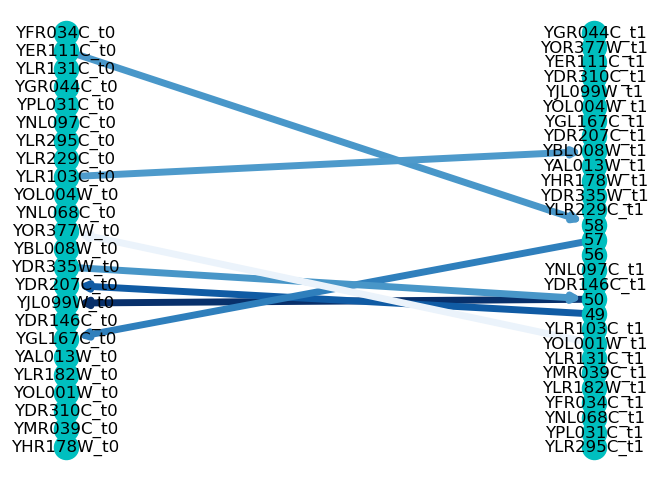

<Figure size 300x200 with 0 Axes>

In [168]:
graph_p = None
graph_p2 = None

graph_p = nx.DiGraph()
graph_p2 = nx.DiGraph()

graph_p.add_nodes_from(range(nnodes*2))
graph_p2.add_nodes_from(range(nnodes*2))

graph_p.add_edges_from(p_edges)
graph_p2.add_edges_from(p_edges)

rnodes = [v + '_t0' for _, v in nodes_names.items()]
rgenes = [v + '_t0' for _, v in nodes_genes.items()]

nodes_names.update({k:v + '_t0' for k, v in nodes_names.items()})
nodes_names.update({k + len(nodes_names):v[:-1] + '1' for k, v in nodes_names.items()})

nodes_genes.update({k:v + '_t0' for k, v in nodes_genes.items()})
nodes_genes.update({k + len(nodes_genes):v[:-1] + '1' for k, v in nodes_genes.items()})

graph_p = nx.relabel_nodes(graph_p, nodes_names, copy=False)
graph_p2 = nx.relabel_nodes(graph_p2, nodes_genes, copy=False)

#pos = nx.shell_layout(graph_y, nlist=[range(nnodes),range(nnodes,nnodes*2)], rotate=0.1, center=(1,5))
pos = nx.bipartite_layout(graph_p, nodes=rnodes)
pos2 = nx.bipartite_layout(graph_p2, nodes=rgenes)

#subax1 = plt.subplot(121)
nx.draw(graph_p, pos, node_color='c', edge_color=p_weights, width=5.0, edge_cmap=plt.cm.Blues, with_labels=True)

#subax2 = plt.subplot(122)
#nx.draw(graph_p2, pos2, node_color='c', edge_color=p_weights, width=5.0, edge_cmap=plt.cm.Blues, with_labels=True)
plt.figure(figsize=(3,2))
plt.show()

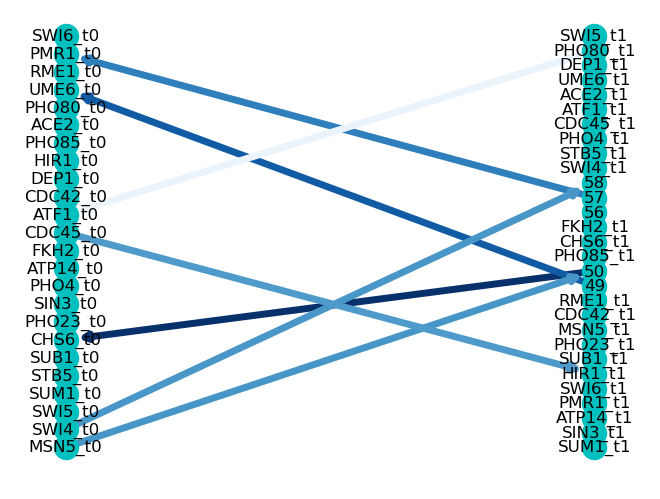

<Figure size 300x200 with 0 Axes>

In [169]:
nx.draw(graph_p2, pos2, node_color='c', edge_color=p_weights, width=5.0, edge_cmap=plt.cm.Blues, with_labels=True)
plt.figure(figsize=(3,2))
plt.show()